In [2]:
! pip install spark-nlp==5.5.3 pyspark
! pip install ekphrasis
! pip install transformers --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 635.7/635.7 kB 10.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.8/83.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.4 MB/s eta 0:00:00


In [3]:
from pyspark.sql import SparkSession
import sparknlp

In [4]:
spark = SparkSession.builder \
    .appName("Hinglish Tweets Sentiment Prediction") \
    .config("spark.driver.memory","16G") \
    .config("spark.kryoserializer.buffer.max","2000M") \
    .config("spark.serializer","org.apache.spark.serializer.KryoSerializer") \
    .config("spark.sql.execution.arrow.pyspark.enabled","true") \
    .config("spark.executor.memory","16G") \
    .config("spark.driver.extraJavaOptions","-XX:+UseG1GC -XX:+UseStringDeduplication") \
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp-gpu_2.12:5.5.3") \
    .getOrCreate()

sparknlp.start()

:: loading settings :: url = jar:file:/usr/local/lib/python3.11/dist-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp-gpu_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-320aaabe-60d9-43d4-9ccc-63b6218da3c3;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp-gpu_2.12;5.5.3 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-s3;1.12.500 in central
	found com.amazonaws#aws-java-sdk-kms;1.12.500 in central
	found com.amazonaws#aws-java-sdk-core;1.12.500 in central
	found commons-logging#commons-logging;1.1.3 in central
	found commons-codec#commons-codec;1.15 in central
	found org.apache.httpcomponents#httpclient;4.5.13 in central
	found org.apache.httpcomponents#httpcore;4.4.13 in central
	found software.amazon.ion#ion-java;1.0.2 in central
	found joda-time#joda-time;2.8.1 in central
	found com.amazonaws#jmespath-java;1.12.500 in central
	fou

25/05/06 22:31:50 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [11]:
df = spark.read.csv("cleaned_file.csv", header=True, inferSchema=True)
print("Original Schema: ", df.printSchema())

root
 |-- Column1: string (nullable = true)
 |-- Column2: string (nullable = true)
 |-- Column3: string (nullable = true)
 |-- Column4: string (nullable = true)

Original Schema:  None


# Data Cleaning and Preprocessing

### Appending New Features for IndicBert Training Using SparkML and PySpark NLP

1. Normalizing Text using Ekphrasis and Custom Rules
2. Detecting Negation in Text Using Regex-Based Matching
3. Part of Speech Tagging
4. Detecting and Extracting Stopwords
5. Calculating Percentage of Stopwords

We applied a structured data cleaning and feature engineering process using SparkML and PySpark NLP to prepare the Hinglish text for training IndicBert. The text was first normalized with Ekphrasis and custom rules to handle inconsistencies. Negation words were detected through regex-based matching to capture sentiment nuances. Part-of-speech tags were added to enrich the linguistic features. We then identified and extracted stopwords from English, Hindi, and a custom Hinglish list, and calculated the percentage of stopwords to better understand text composition. These steps ensured the data was clean, consistent, and ready for large-scale model training.

In [5]:
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from pyspark.sql import functions as F
from pyspark.sql.functions import regexp_replace, col, lower, when, udf, array_join, split, concat_ws
from pyspark.ml import Pipeline
from pyspark.sql.types import StringType, ArrayType, StructType, StructField, FloatType, IntegerType
from sparknlp.base import DocumentAssembler, Finisher
from pyspark.ml.feature import HashingTF, IDF, StringIndexer, ChiSqSelector, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import Tokenizer as py_tokenizer
from pyspark.ml.classification import RandomForestClassifier
from sparknlp.annotator import ContextSpellCheckerModel, NerConverter, NerDLModel, Tokenizer, Normalizer, StopWordsCleaner, PerceptronModel
from sparknlp.base import LightPipeline, PipelineModel
from sparknlp.annotator import *
from sparknlp.common import *
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import sparknlp
import os
import re
import shutil

In [13]:
df_cleaned = df.drop("Column3", "Column4")

In [14]:
print("Cleaned Data:")
df_cleaned.show(truncate=False)

Cleaned Data:
+--------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------+
|Column1                                                                         |Column2                                                                                    |
+--------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------+
|en_query                                                                        |cs_query                                                                                   |
|Who is the featured performer at The Grand Ole Opry this Saturday night         |Is Saturday night The Grand Ole Opry me featured performer kya hai                         |
|Remind me of my meeting at 12 am                                                |mujhe 12 am ko meri meeting k

In [15]:
df_cleaned = df_cleaned.withColumnRenamed("Column1", "English_Text")\
                       .withColumnRenamed("Column2", "Hinglish_Text")

df_cleaned.show(truncate=False)

+--------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------+
|English_Text                                                                    |Hinglish_Text                                                                              |
+--------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------+
|en_query                                                                        |cs_query                                                                                   |
|Who is the featured performer at The Grand Ole Opry this Saturday night         |Is Saturday night The Grand Ole Opry me featured performer kya hai                         |
|Remind me of my meeting at 12 am                                                |mujhe 12 am ko meri meeting ke baare me yaa

In [16]:
df_cleaned = df_cleaned.filter((df_cleaned["English_Text"] != "en_query") & (df_cleaned["Hinglish_Text"] != "csquery"))

In [17]:
df_cleaned.show(truncate=False)

+--------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------+
|English_Text                                                                    |Hinglish_Text                                                                              |
+--------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------+
|Who is the featured performer at The Grand Ole Opry this Saturday night         |Is Saturday night The Grand Ole Opry me featured performer kya hai                         |
|Remind me of my meeting at 12 am                                                |mujhe 12 am ko meri meeting ke baare me yaad dilaayen                                      |
|set an alarm for 5 am                                                           |subha 5 baje ke liye ek alarm set karen    

In [18]:
# Dropping duplicates
df_cleaned = df_cleaned.dropDuplicates()
df_cleaned.show(truncate=False)

+--------------------------------------------------------------------------+---------------------------------------------------------------------------+
|English_Text                                                              |Hinglish_Text                                                              |
+--------------------------------------------------------------------------+---------------------------------------------------------------------------+
|Set a reminder to place an order for work at noon today                   |aj dopahar ko work ke liye order plac karne ke liye reminder set kare      |
|When is sun in the forecast for this week ?                               |is week ke liye sun kab forecast me hai ?                                  |
|How many reminders for setting out the trash have I had so far this year ?|is saal maine kachra baahar nikalne ke liye kitne reminders gehae hai ?    |
|Christmas lights near Philadelphia open now                               |Philad

In [19]:
# No of rows reduced from 1,40,000 to 1,30,326!
df_cleaned.count()

130326

In [20]:
output_path = "cleaned_output_stage1.csv"
df_cleaned.coalesce(1).write.mode("overwrite").option("header", True).csv("cleaned_output_tmp")

In [21]:
# Downloading the file
# Listing the generated files
for file in os.listdir("cleaned_output_tmp"):
    if file.startswith("part-") and file.endswith(".csv"):
        shutil.move(f"cleaned_output_tmp/{file}", output_path)
        break

shutil.rmtree("cleaned_output_tmp")

print(f"CSV saved as: {output_path}")

CSV saved as: cleaned_output_stage1.csv


In [22]:
# Removing odd characters, emojis, or non-text symbols
df_cleaned = df_cleaned.withColumn("English_Text", regexp_replace(col("English_Text"), r"[^a-zA-Z0-9\u0900-\u097F\s.,!?']", ""))
df_cleaned = df_cleaned.withColumn("Hinglish_Text", regexp_replace(col("Hinglish_Text"), r"[^a-zA-Z0-9\u0900-\u097F\s.,!?']", ""))

df_cleaned.show(truncate = True)

+--------------------+--------------------+
|        English_Text|       Hinglish_Text|
+--------------------+--------------------+
|Set a reminder to...|aj dopahar ko wor...|
|When is sun in th...|is week ke liye s...|
|How many reminder...|is saal maine kac...|
|Christmas lights ...|Philadelphia ke a...|
|How long will it ...|agar mai abhi nik...|
|Tune to Mickey Mo...|Mickey Mouse chan...|
|Tell me the weath...|Muje aaj dopahar ...|
|message Pauline t...|Pauline ko messag...|
|Are the roads cle...|kya aj subah work...|
|Remind me to make...|mujhe agley hafte...|
|Show me the alarm...|Mujhe aaj ke liye...|
|Can I listen to l...|Kya mai luke brya...|
|set my morning al...|30 minutes pehle ...|
| can you go to chats|kya aap chats par...|
|how long will it ...|yaha se mujhe wal...|
|i don ' t want to...|mai video message...|
|create a daily al...|agley mahine ke l...|
|Shoot a text to m...|mere cousins Stev...|
|Message Benji to ...|Benji ko message ...|
|To get to Vegas f...|meri siste

### Appending new columns(features) for training IndicBert effectively

### Normalizing Text using Ekphrasis and Custom Rules

To standardize the Hinglish text input, we built a hybrid normalization pipeline. Ekphrasis was used to handle English-specific inconsistencies such as fixing HTML tokens, hashtags, and contractions. For Hinglish-specific issues, a custom dictionary of common misspellings and a regex-based de-elongation approach were applied. Tokenization was performed using Spark NLP's DocumentAssembler and Tokenizer, and PySpark UDFs were used to normalize tokens efficiently. The final cleaned text was stored in a new feature called Normalized_Hinglish_Text, ready for downstream modeling.

In [ ]:
# Utilizing ekphrasis for English token inconsistency handling
text_processor = TextPreProcessor(
    normalize=[],
    annotate={},  # avoids extra annotations
    fix_html=True,  # fix HTML tokens
    segmenter="twitter",  # social media style text segmenter
    corrector="twitter",  # correct social media spelling
    unpack_hashtags=True,
    unpack_contractions=True,
    spell_correct_elong=False,  # disable repeated letter spell-correction here as we are handling it manually)
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    dicts=[]
)

# My dictionary of common Hinglish misspellings/mistakes I identified along with their corresponding corrections
common_mistakes = {
    "muje": "mujhe", "muze": "mujhe", "apka": "aapka", "apke": "aapke", "acha": "achha", "accha": "achha", "han": "haan", "ha": "haan", "nai": "nahi",
    "nhi": "nahi", "bahot": "bahut", "bohot": "bahut", "bahuth": "bahut", "kese": "kaise", "kesi": "kaisi", "esa": "aisa", "aise": "aisa",
    "kon": "kaun", "konse": "kaunse", "kyu": "kyun", "kyo": "kyun", "ky": "kya", "mai": "main", "me": "mein", "hu": "hoon", "hona": "honaa",
    "gya": "gaya", "gyi": "gayi", "hogya": "hogaya", "hogayi": "hogayi", "aayi": "aai", "aaie": "aai", "jaaie": "jaai", "kahiye": "kahiye",
    "kahi": "kahi", "krna": "karna", "karo": "karo", "lo": "lo", "le": "le", "de": "de", "btao": "batao", "btaaye": "bataiye", "btana": "batana",
    "btayiye": "bataiye", "raha": "raha", "rahi": "rahi", "rha": "raha", "rhi": "rahi", "kaam": "kaam", "kam": "kaam", "pani": "paani", "sahi": "sahi",
    "galat": "galat", "kharab": "kharab", "acchi": "achhi"
}

# Collapsing 2 or more repeating letters into one (This is pre-compiled)
_repeated_char_pattern = re.compile(r"([A-Za-z])\1+")

def normalize_token(token):
  if not token:
    return token

  token = token.lower()

  # using ekphrasis (handling English Text)
  processed_tokens = text_processor.pre_process_doc(token) # it will be a list
  if processed_tokens:
    token = processed_tokens[0]

  # using manual approach (handling Hinglish Text)
  # collapsing elongated sequences of the same letter to a single letter
  token = _repeated_char_pattern.sub(r"\1", token)

  # finally applying custom hinglish corrections
  token = common_mistakes.get(token, token)

  return token

# Defining sparkUDF to normalize the list of tokens
@udf(ArrayType(StringType()))
def normalize_token_udf(tokens):
  if tokens is None:
    return []
  return [normalize_token(tok) for tok in tokens]

document_assembler = DocumentAssembler() \
                    .setInputCol("Hinglish_Text") \
                    .setOutputCol("document")

tokenizer = Tokenizer() \
            .setInputCols(["document"]) \
            .setOutputCol("tokens")

pipeline = Pipeline(stages = [document_assembler, tokenizer])
tokenizer_model = pipeline.fit(df_cleaned)
tokenized_df = tokenizer_model.transform(df_cleaned)

# Finally applying the hybrid normalization!
df_cleaned = tokenized_df.withColumn("Normalized_Hinglish_Text", normalize_token_udf(col("tokens.result")))
# joining the token into single string!
df_cleaned = df_cleaned.withColumn("Normalized_Hinglish_Text", array_join(col("Normalized_Hinglish_Text"), " "))

df_cleaned.select("Hinglish_Text", "Normalized_Hinglish_Text").show(truncate=False)

Word statistics files not found!
Downloading... 

/usr/local/lib/python3.11/dist-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


done!
Unpacking... done!
Reading twitter - 1grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_1grams.txt
Reading twitter - 2grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_2grams.txt


/usr/local/lib/python3.11/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


Reading twitter - 1grams ...
+---------------------------------------------------------------------------+--------------------------------------------------------------------------+
|Hinglish_Text                                                              |Normalized_Hinglish_Text                                                  |
+---------------------------------------------------------------------------+--------------------------------------------------------------------------+
|aj dopahar ko work ke liye order plac karne ke liye reminder set kare      |aj dopahar ko work ke liye order plac karne ke liye reminder set kare     |
|is week ke liye sun kab forecast me hai ?                                  |is wek ke liye sun kab forecast mein hai ?                                |
|is saal maine kachra baahar nikalne ke liye kitne reminders gehae hai ?    |is sal maine kachra bahar nikalne ke liye kitne reminders gehae hai ?     |
|Philadelphia ke aas pas ke Christmas lights abhi khu

#### Detecting Negation in Text Using Regex-Based Matching

Since Spark NLP does not provide a direct solution for detecting negation in non-healthcare text, a custom regex-based method was implemented. A comprehensive list of English and Hindi negation words was manually curated. Using PySpark's when and rlike functions, we scanned the English_Text column and created a new binary feature has_negation, marking sentences containing negations for enhanced model learning.

In [ ]:
! pip list | grep sparknlp

In [25]:
# Here, acc to my research I never found a sparknlp lib that can identify negation in a given text for non-healthcare data. There is only a lib that can identify negation but is only restrcited to healthcare data!
negation_words = [
    # my english list
    "no", "not", "never", "none", "nothing", "neither", "nor", "nobody", "nowhere",
    "can't", "cannot", "couldn't", "won't", "wouldn't", "don't", "doesn't", "didn't",
    "isn't", "aren't", "wasn't", "weren't", "haven't", "hasn't", "hadn't",
    "shouldn't", "mightn't", "mustn't", "without",
    # my hindi list
    "nahi", "nahin", "mat", "na", "naa", "bina", "bin", "nah", "kabhi nahi", "bilkul nahi",
]

negation_regex = r'(^|[^a-zA-Z])(' + '|'.join([w.replace(' ', r'\s+') for w in negation_words]) + r')([^a-zA-Z]|$)'

In [26]:
df_cleaned = df_cleaned.withColumn(
    "has_negation",
    when(lower(col("English_Text")).rlike(negation_regex), 1).otherwise(0)
)

negation_regex = r'(^|[^a-zA-Z])(' + '|'.join(negation_words) + r')([^a-zA-Z]|$)'

In [27]:
df_cleaned.select("English_Text", "Normalized_Hinglish_Text", "has_negation").show(truncate=False)

+--------------------------------------------------------------------------+--------------------------------------------------------------------------+------------+
|English_Text                                                              |Normalized_Hinglish_Text                                                  |has_negation|
+--------------------------------------------------------------------------+--------------------------------------------------------------------------+------------+
|Set a reminder to place an order for work at noon today                   |aj dopahar ko work ke liye order plac karne ke liye reminder set kare     |0           |
|When is sun in the forecast for this week ?                               |is wek ke liye sun kab forecast mein hai ?                                |0           |
|How many reminders for setting out the trash have I had so far this year ?|is sal maine kachra bahar nikalne ke liye kitne reminders gehae hai ?     |0           |
|Christmas

### Part of Speech Tagging

There are three major pos_tags models that we can use for pos tagging of words!
1. pos_hiencs (Hindi-English)
2. pos_anc (Default English)
3. pos_hdtb (Hindi)

First, we manually annotated the first 100 Hinglish sentences with correct POS tags to create a small ground-truth dataset for evaluation. Then, we used Spark NLP to apply three different POS models (pos_hiencs, pos_anc, and pos_hdtb) on our Normalized_Hinglish_Text. We normalized the POS tags from all models to a common Penn Treebank format to make a fair comparison. After that, we compared each model’s predictions against my manually created ground-truth at the word level.

Finally, we calculated accuracy for each model and visualized the results using a simple bar chart to find which model performed the best.

In [33]:
# Let us compare the three models and find out the best one!
test_df = df_cleaned.select("Normalized_Hinglish_Text").dropna().limit(101)
test_df.show(truncate=False)

def pos_tag_with_model(df, text_col, model_name, lang):
    document_assembler = DocumentAssembler() \
        .setInputCol(text_col) \
        .setOutputCol("document")

    tokenizer = Tokenizer() \
        .setInputCols(["document"]) \
        .setOutputCol("token")

    pos_tagger = PerceptronModel.pretrained(model_name, lang) \
        .setInputCols(["document", "token"]) \
        .setOutputCol("pos")

    pipeline = Pipeline(stages=[document_assembler, tokenizer, pos_tagger])
    pos_model = pipeline.fit(df)
    result = pos_model.transform(df)

    token_pos = result.select(
        F.explode(
            F.arrays_zip(result.token.result, result.pos.result)
        ).alias("cols")
    ).select(
        F.col("cols.0").alias("token"),
        F.col("cols.1").alias("pos")
    )

    collected = token_pos.collect()

    pandas_df = pd.DataFrame([(row['token'], row['pos']) for row in collected], columns=["token", "pos"])
    return pandas_df

# Applying this to all the three models!
pos_hiencs = pos_tag_with_model(test_df, "Normalized_Hinglish_Text", "pos_hiencs", "qhe")
pos_anc = pos_tag_with_model(test_df, "Normalized_Hinglish_Text", "pos_anc", "en")
pos_hdtb = pos_tag_with_model(test_df, "Normalized_Hinglish_Text", "pos_hdtb", "hi")

+------------------------------------------------------------------------+
|Normalized_Hinglish_Text                                                |
+------------------------------------------------------------------------+
|aj dopahar ko work ke liye order plac karne ke liye reminder set kare   |
|is wek ke liye sun kab forecast mein hai ?                              |
|is sal maine kachra bahar nikalne ke liye kitne reminders gehae hai ?   |
|philadelphia ke as pas ke christmas lights abhi khul gaye hai           |
|agar main abhi nikalta hon toh mujhe usc pahuchne mei kitni der lagegi ?|
|mickey mouse chanel par jaye                                            |
|mujhe aj dopahar 2 baje ka weather bataye .                             |
|pauline ko mesage karo ki thank you very much for the lunch .           |
|kya aj subah work ke liye roads saf hai                                 |
|mujhe agley haftey ke liye hair apointment lene ke liye yad dilaye      |
|mujhe aj ke liye alarms 

In [34]:
# Loading my ground_truth_label_1000 (manually annotated (POS_tagged)) file!
ground_truth = pd.read_csv("/content/first_11_pos_tagged.csv")

In [35]:
# Normalizing in Penn Treebank convention (defining a normalizing mapping dict) for accurate comparision
normalization_mapping = {
    # Common mappings for Hindi/Multilingual models
    "PROPN": "NNP",
    "NOUN": "NN",
    "VERB": "VB",
    "ADJ": "JJ",
    "ADV": "RB",
    "PRON": "PRP",
    "ADP": "IN",   # prepositions
    "DET": "DT",   # determiners
    "NUM": "CD",   # cardinal numbers
    "CONJ": "CC",  # coordinating conjunction
    "CCONJ": "CC", # coordinating conjunction (alt form)
    "SCONJ": "IN", # subordinating conjunctions mapped as prepositions
    "PART": "RP",  # particle
    "INTJ": "UH",  # interjection
    "SYM": "SYM",  # symbol
    "PUNCT": ".",
    "AUX": "VB",   # auxiliary verbs as main verb
    "X": "FW",     # foreign words
    "ROOT": "VB",  # ROOT sometimes appears, treating it as verb
    "OTH": "NN",   # catch-all unknowns
}

# If mapping not found keep the pos as it is!
def normalize_pos_tag(tag):
  return normalization_mapping.get(tag, tag)

def normalize_pos_df(pos_df):
  pos_df_normalized = pos_df.copy()
  pos_df_normalized["pos"] = pos_df_normalized["pos"].apply(normalize_pos_tag)
  return pos_df_normalized

# Verifying it (this will give sentence-level tokenization)
normalized_pos_hiencs = normalize_pos_df(pos_hiencs)
normalized_pos_anc = normalize_pos_df(pos_anc)
normalized_pos_hdtb = normalize_pos_df(pos_hdtb)

print(normalized_pos_hiencs)
print(normalized_pos_anc)
print(normalized_pos_hdtb)

       token  pos
0         aj    .
1    dopahar  NNP
2         ko   NN
3       work   NN
4         ke   NN
..       ...  ...
111       aj  NNP
112       ke   NN
113     liye   NN
114   alarms   VB
115   dikhao    .

[116 rows x 2 columns]
       token  pos
0         aj   NN
1    dopahar   NN
2         ko   NN
3       work   NN
4         ke   NN
..       ...  ...
111       aj   NN
112       ke   NN
113     liye   NN
114   alarms  NNS
115   dikhao   NN

[116 rows x 2 columns]
       token  pos
0         aj  NNP
1    dopahar  NNP
2         ko  NNP
3       work  NNP
4         ke  NNP
..       ...  ...
111       aj  NNP
112       ke  NNP
113     liye  NNP
114   alarms  NNP
115   dikhao  NNP

[116 rows x 2 columns]


In [36]:
# But we will need word-level tokenization for comparision!
def explode_ground_truth(ground_truth_df):
  exploded_rows = []
  for index, row in ground_truth_df.iterrows():
    tokens = row["Hinglish_Text"].split()
    pos_tags = row["pos_tags"].split()
    for token, pos_tag in zip(tokens, pos_tags):
      exploded_rows.append({"token": token, "pos": pos_tag})
  return pd.DataFrame(exploded_rows)

ground_truth_exploded = explode_ground_truth(ground_truth)
ground_truth_exploded.head()

,token,pos
0,aj,NN
1,dopahar,NN
2,ko,IN
3,work,NN
4,ke,IN


In [37]:
# Defining the acc metrics
def compute_accuracy(pred_df, ground_truth_df):
  correct = (pred_df["pos"].reset_index(drop = True) == ground_truth_df["pos"].reset_index(drop = True)).sum()
  total = len(ground_truth_df)
  return (correct/total)*100

accuracy_hiencs = compute_accuracy(normalized_pos_hiencs, ground_truth_exploded)
accuracy_anc = compute_accuracy(normalized_pos_anc, ground_truth_exploded)
accuracy_hdtb = compute_accuracy(normalized_pos_hdtb, ground_truth_exploded)

print("Accuracy for pos_hiencs: ", accuracy_hiencs)
print("Accuracy for pos_anc: ", accuracy_anc)
print("Accuracy for pos_hdtb: ", accuracy_hdtb)

Accuracy for pos_hiencs:  22.413793103448278
Accuracy for pos_anc:  36.206896551724135
Accuracy for pos_hdtb:  9.482758620689655


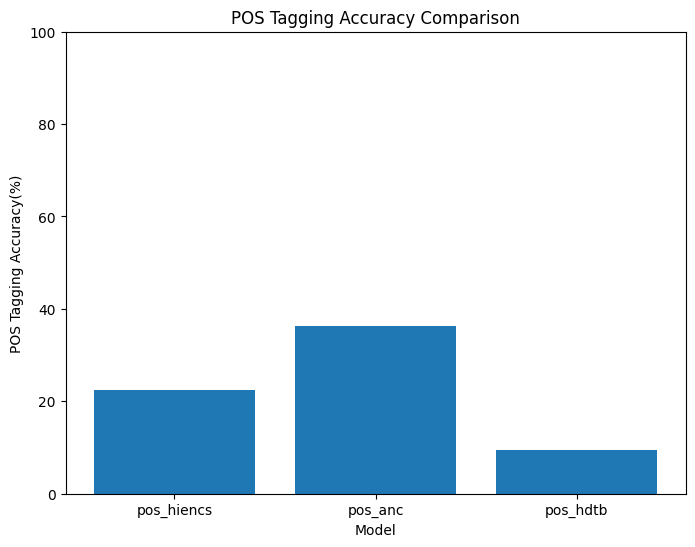

In [38]:
# Identifying the best model
# Bar Plot for comparison
models = ['pos_hiencs', 'pos_anc', 'pos_hdtb']
accuracies = [accuracy_hiencs, accuracy_anc, accuracy_hdtb]

plt.figure(figsize=(8, 6))
plt.bar(models, accuracies)
plt.xlabel('Model')
plt.ylabel('POS Tagging Accuracy(%)')
plt.title('POS Tagging Accuracy Comparison')
plt.ylim(0, 100)
plt.show()

In [39]:
# So from above, we identified that pos_anc works best for pos_tagging on 11 text samples, although pos_hiencs is tweaked for working on Hinglish texts!
spark = sparknlp.start()

# Defining the pipeline stages for POS tagging
document_assembler = DocumentAssembler() \
                    .setInputCol("English_Text") \
                    .setOutputCol("document")

tokenizer = Tokenizer() \
            .setInputCols(["document"]) \
            .setOutputCol("token")

# Hence using pos_anc, which is an opensorce pos_tagging model provided by JohnSnow labs!
pos_model = PerceptronModel.pretrained("pos_anc", "en") \
        .setInputCols(["document", "token"]) \
        .setOutputCol("pos")

finisher = Finisher() \
           .setInputCols(["pos"]) \
           .setOutputCols("pos_tags")

# Assembling and running the pipeline
pos_pipeline = Pipeline().setStages([document_assembler, tokenizer, pos_model, finisher])
pos_pipeline_model = pos_pipeline.fit(df_cleaned)
df_cleaned = pos_pipeline_model.transform(df_cleaned)

df_cleaned = df_cleaned.withColumn("pos_tags", array_join("pos_tags", " "))

df_cleaned.select("English_Text", "Normalized_Hinglish_Text", "has_negation", "pos_tags")

pos_anc download started this may take some time.
Approximate size to download 3.9 MB
[OK!]


DataFrame[English_Text: string, Normalized_Hinglish_Text: string, has_negation: int, pos_tags: string]

In [40]:
df_cleaned.select("English_Text", "Normalized_Hinglish_Text", "has_negation", "pos_tags").show(truncate=False)

+--------------------------------------------------------------------------+--------------------------------------------------------------------------+------------+-----------------------------------------------------------+
|English_Text                                                              |Normalized_Hinglish_Text                                                  |has_negation|pos_tags                                                   |
+--------------------------------------------------------------------------+--------------------------------------------------------------------------+------------+-----------------------------------------------------------+
|Set a reminder to place an order for work at noon today                   |aj dopahar ko work ke liye order plac karne ke liye reminder set kare     |0           |NNP DT NN TO VB DT NN IN NN IN NN NN                       |
|When is sun in the forecast for this week ?                               |is wek ke liye sun kab f

In [41]:
# Let us take one example to see if words are correctly mapped to their corresponding pos tags!
def hinglish_pos_tags(df, text_col):
  # defining stages
  document_assembler = DocumentAssembler() \
                    .setInputCol(text_col) \
                    .setOutputCol("document")

  tokenizer = Tokenizer() \
            .setInputCols(["document"]) \
            .setOutputCol("token")

  pos_tagger = PerceptronModel.pretrained("pos_anc", "en") \
            .setInputCols(["document", "token"]) \
            .setOutputCol("pos")

  # building pipeline
  pipeline = Pipeline(stages = [document_assembler, tokenizer, pos_tagger])
  pos_model = pipeline.fit(df)
  result = pos_model.transform(df)

  # # extracting tokens and pos_tags
  # F.explode: maps col to rows
  token_pos = result.select(
      F.explode(
          F.arrays_zip(result.token.result, result.pos.result)
      ).alias("cols")
  ).select(
      F.col("cols.0").alias("token"),
      F.col("cols.1").alias("pos")
  )

  collected = token_pos.collect()
  output = [{"token": row["token"], "pos": row["pos"]} for row in collected]

  return output

In [42]:
# Example from dataset!
data = [("yaha se mujhe walmart pahuchne mei kitni der lagegi",)]
columns = ["Normalized_Hinglish_Text"]
df = spark.createDataFrame(data, columns)
print(df)

# calling my 'hinglish_pos_tags' func
output = hinglish_pos_tags(df, "Normalized_Hinglish_Text")
print(output)


DataFrame[Normalized_Hinglish_Text: string]
pos_anc download started this may take some time.
Approximate size to download 3.9 MB
[OK!]
[{'token': 'yaha', 'pos': 'NN'}, {'token': 'se', 'pos': 'FW'}, {'token': 'mujhe', 'pos': 'NN'}, {'token': 'walmart', 'pos': 'NN'}, {'token': 'pahuchne', 'pos': 'NN'}, {'token': 'mei', 'pos': 'NN'}, {'token': 'kitni', 'pos': 'NN'}, {'token': 'der', 'pos': 'NN'}, {'token': 'lagegi', 'pos': 'NN'}]


### Detecting and Extracting Stopwords

### Calculating Percentage of Stopwords

We applied Spark NLP’s pretrained StopWordsCleaner models separately on both the "English_Text" and "Normalized_Hinglish_Text" columns to detect standard English and Hindi stopwords. To further improve accuracy, we designed a custom Hinglish stopword set and added it as an additional layer. After combining all stopwords, two features were created: all_stopwords (list of all detected stopwords) and stopwords_percentage (the proportion of stopwords in the text). The entire process was efficiently implemented using SparkML pipelines to ensure scalability across large datasets.



In [43]:
# Custom Hinglish stopwords list
custom_hinglish_stopwords = [
    "hai",  "kya", "ke", "ki", "ko", "ka", "mein", "me", "par", "se", "aur", "ab", "nahi",
    "tha", "thi", "the", "hogi", "hogaya", "hogayi", "hone", "hota", "hoti", "hona",
    "tak", "liye", "ja", "raha", "rahi", "rha", "rhi", "mai", "mujhe", "tum", "apna",
    "apne", "apni", "unka", "unki", "unke", "mere", "meri", "mereko", "ye", "vo",
    "wo", "kab", "kaise", "kyon", "kis", "kisi", "kisi bhi", "sab", "har", "bahut", "zyada"
]

document_assembler = DocumentAssembler() \
                  .setInputCol("Normalized_Hinglish_Text") \
                  .setOutputCol("document")

tokenizer = Tokenizer() \
          .setInputCols(["document"]) \
          .setOutputCol("token")

# Initializing English Stopwords:
stopwords_cleaner_en = StopWordsCleaner.pretrained("stopwords_en", "en") \
                      .setInputCols("token") \
                      .setOutputCol("cleaned_token_en") \
                      .setCaseSensitive(False)

# Initializing Hindi Stopwords:
stopwords_cleaner_hi = StopWordsCleaner.pretrained("stopwords_hi", "hi") \
                      .setInputCols("token") \
                      .setOutputCol("cleaned_token_hi") \
                      .setCaseSensitive(False)

# Pipeline
pipeline = Pipeline(stages = [document_assembler, tokenizer, stopwords_cleaner_en, stopwords_cleaner_hi])
stopwords_model = pipeline.fit(df_cleaned)
result = stopwords_model.transform(df_cleaned)

# Creating two features:
# 1. Stopwords
# First of all extracting original tokens
result = result.withColumn("all_tokens", F.col("token.result"))

# Now computing Stopwords using pretrained model
result = result.withColumn("en_stopwords", F.expr("array_except(all_tokens, cleaned_token_en.result)")) \
               .withColumn("hi_stopwords", F.expr("array_except(all_tokens, cleaned_token_hi.result)"))
result = result.withColumn("all_stopwords", F.array_union("en_stopwords", "hi_stopwords"))

# Now including custom list to it as well!
@F.udf("array<string>")
def detect_custom_stopwords(tokens):
  if tokens is None:
    return []
  return [t for t in tokens if t.lower() in custom_hinglish_stopwords]
result = result.withColumn("custom_hinglish_stopwords", detect_custom_stopwords(F.col("all_tokens")))

# Final stopwords list!
result = result.withColumn("all_stopwords", F.array_union("all_stopwords", "custom_hinglish_stopwords"))

# 2. Computing % of stopwords
result = result.withColumn("total_tokens", F.size("all_tokens")) \
               .withColumn("stopwords_count", F.size("all_stopwords")) \
               .withColumn("stopwords_percentage", (F.col("stopwords_count") / F.col("total_tokens"))*100)

# Finally adding the new features into the table
df_cleaned = df_cleaned.join(result.select("Normalized_Hinglish_Text", "English_Text", "all_stopwords", "stopwords_percentage"), on=["English_Text", "Normalized_Hinglish_Text"], how="left")

stopwords_en download started this may take some time.
Approximate size to download 2.9 KB
[OK!]
stopwords_hi download started this may take some time.
Approximate size to download 2.2 KB
[OK!]


In [ ]:
# df_cleaned.select("English_Text", "Normalized_Hinglish_Text", "has_negation", "pos_tags", "all_stopwords", "stopwords_percentage").show(truncate=False)

In [ ]:
# # Storing stage2 file with 4 features integrated
# converting array-cols to csv strings!
df_cleaned = df_cleaned.withColumn("all_stopwords", concat_ws(",", "all_stopwords"))
df_cleaned.select("English_Text", "Normalized_Hinglish_Text", "has_negation", "pos_tags", "all_stopwords", "stopwords_percentage").show(truncate=False)

output_path = "cleaned_output_stage2.csv"
df_cleaned.coalesce(1).write.mode("overwrite").option("header", True).csv("cleaned_output_tmp2")

for file in os.listdir("cleaned_output_tmp2"):
    if file.startswith("part-") and file.endswith(".csv"):
        shutil.move(f"cleaned_output_tmp2/{file}", output_path)
        break

shutil.rmtree("cleaned_output_tmp2")

print(f"CSV saved as: {output_path}")

+----------------------------------------------------------------------------------+-------------------------------------------------------------------------------------+------------+-------------------------------------------------------------+--------------------------+--------------------+
|English_Text                                                                      |Normalized_Hinglish_Text                                                             |has_negation|pos_tags                                                     |all_stopwords             |stopwords_percentage|
+----------------------------------------------------------------------------------+-------------------------------------------------------------------------------------+------------+-------------------------------------------------------------+--------------------------+--------------------+
|Are we expecting rain today ?                                                     |kya aj barish ki umed karsakte hai

# Performing Supervised Learning

In this step, we are moving to a supervised learning approach.
But before we can actually train any model, we need labeled data — that is, each text should have a sentiment label: positive, or negative.

Now, instead of manually labeling thousands of rows, we are using a pretrained HuggingFace model, specifically distilbert-base-uncased-finetuned-sst-2-english, to automatically annotate sentiments.
This model is small, lightweight, but pretty accurate — perfect for quick labeling!

One important thing:
Although we're predicting sentiment based on the English text, later during model training, we'll use the Normalized Hinglish Text along with other features.
This way, we leverage English annotations but train the model for Hinglish understanding.

# Manual Sentiment Labelling

Since we didn’t have sentiment labels initially, I decided to generate them first. I used the English_Text column because it’s easier for models to understand, and passed it through a lightweight HuggingFace model, distilbert-base-uncased-finetuned-sst-2-english, on GPU for faster predictions. To avoid memory issues, I predicted in small batches of 32. After getting the sentiment results, I added them back to the dataset and merged everything properly, so that now each row had a sentiment label ready for training.

In [ ]:
# As performing supervised learning, our approach is to first craete a Sentiment Col and annotate it with 'positive/negative/neutral' using pretrained SentimentDLModel from SparkML lib
# There is a twist! Here, we would use 'English_Text' col to annotate Sentiment Col but during training we would 'Normalized_Hingligh_Text' as our feature along with other features to train the IndicBert model
#  Using Transformer + SparkNLP

# ConvertING only 'English_Text' columns to Pandas (small memory)
english_text_pd = df_cleaned.select("English_Text").toPandas()

# loading HuggingFace Sentiment Pipeline
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",  # small and accurate acc to me!
    device=0  # for GPU!
)

# Here is our predicting sentiment process
batch_size = 32
results = []

# predicting in batches to avoid memory overflow
for i in range(0, len(english_text_pd), batch_size):
    batch_texts = english_text_pd["English_Text"].iloc[i:i+batch_size].tolist()
    batch_results = sentiment_pipeline(batch_texts)
    batch_labels = [r['label'].lower() for r in batch_results]
    results.extend(batch_labels)

# adding Sentiment back to PD
english_text_pd["Sentiment"] = results

# finally merging back with original Spark DataFrame
sentiment_spark_df = spark.createDataFrame(english_text_pd)

# joining bcak with og df_cleaned!
df_cleaned = df_cleaned.join(sentiment_spark_df, on="English_Text", how="left")

df_cleaned.select("English_Text", "Sentiment").show(5, truncate=False)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


+-------------------------------------------------------+---------+
|English_Text                                           |Sentiment|
+-------------------------------------------------------+---------+
|Are we expecting rain today ?                          |negative |
|How long will it take me to get to USC if I leave now ?|negative |
|How many miles from here to Tampa , Florida            |negative |
|Set a reminder to place an order for work at noon today|positive |
|Tune to Mickey Mouse channel                           |positive |
+-------------------------------------------------------+---------+
only showing top 5 rows



In [ ]:
# Saving File with manual sentiment labelling!
# converting array-cols to csv strings!
df_cleaned = df_cleaned.withColumn("all_stopwords", concat_ws(",", "all_stopwords"))
output_path = "cleaned_output_withSentiment.csv"
df_cleaned.coalesce(1).write.mode("overwrite").option("header", True).csv("cleaned_output_tmp3")

for file in os.listdir("cleaned_output_tmp3"):
    if file.startswith("part-") and file.endswith(".csv"):
        shutil.move(f"cleaned_output_tmp3/{file}", output_path)
        break

shutil.rmtree("cleaned_output_tmp3")

print(f"CSV saved as: {output_path}")

CSV saved as: cleaned_output_withSentiment.csv


# Tracking Feature Importance (Numerical Features)

Before diving into model training, I wanted to quickly check how important my handcrafted features were. First, I converted the Sentiment column into numeric labels because machine learning models need numbers, not text. Then, I assembled my two numerical features: has_negation and stopwords_percentage into a single vector. I ran a Random Forest on it, mainly to get the feature importance scores. This helped me understand which features were actually useful and which ones I could maybe ignore later.


In [ ]:
# necessary to convert sentiment into numeric representation!
label_indexer = StringIndexer(inputCol="Sentiment", outputCol="label")
df_cleaned = label_indexer.fit(df_cleaned).transform(df_cleaned)

# assembling all non-tokenized vectors
initial_assembler = VectorAssembler(
    inputCols = ["has_negation", "stopwords_percentage"],
    outputCol = "initial_assembled_features"
)
initial_assembled_data = initial_assembler.transform(df_cleaned)

# Using RandomForest Classifier to compute Feature Importance!
rf_classifier = RandomForestClassifier(
    labelCol = "label",
    featuresCol = "initial_assembled_features",
    numTrees = 10,
    seed = 42
)
model = rf_classifier.fit(initial_assembled_data)

# Finally printing importance
for feature_name, importance in zip(["has_negation", "stopwords_percentage"], model.featureImportances.toArray()):
  print(f"{feature_name}: {importance}")

has_negation: 0.024394678426230984
stopwords_percentage: 0.975605321573769


# Granular-Level Feature Selection

To make sure we’re only feeding the most important information to the model, we did a granular feature selection step. First, we encoded the Sentiment column into numbers for machine learning. Then, we tokenized the Normalized_Hinglish_Text and converted it into a fixed-size TF-IDF representation, which basically highlights important words across the data. I also included my stopwords_percentage feature. After putting everything together, we applied Chi-Square Selection to pick the top 100 most relevant features. This way, the model focuses only on the strongest signals related to sentiment, without getting distracted by unnecessary noise.

# About ChiSqSelector
ChiSqSelector works by statistically testing the dependency between each feature and the label using a Chi-Squared test. The features with higher correlation to the sentiment (label) are retained, while irrelevant or weakly correlated features are discarded.

For example, if the word "nahi" (indicating negation) appears frequently in negative sentiment samples, ChiSqSelector would recognize its strong correlation with negative labels and keep it as an important feature. Similarly, if stopwords_percentage shows no meaningful relation to sentiment prediction, it would be eliminated automatically, making the final input lighter and more focused for IndicBERT training.

In [ ]:
df_cleaned = spark.read.csv("/content/cleaned_output_withSentiment.csv", header=True, inferSchema=True)

df_cleaned = df_cleaned.dropna()

# Creating a label column for Predicted Sentiment label
label_indexer = StringIndexer(inputCol="Sentiment", outputCol="label")
df_cleaned = label_indexer.fit(df_cleaned).transform(df_cleaned)

# Handling text data (Normalized_Hinglish_Text)
# Vectorizing the text using SparkMLlib's TF-IDF
tokenizer = py_tokenizer(inputCol="Normalized_Hinglish_Text", outputCol="words")
wordsData = tokenizer.transform(df_cleaned)

# HashingTF instance converts tokenized words into a fixed-length feature vector
# "rawFeatures" will store the raw term frequency vectors
hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=5000) # numFeatures: size of feature vector space

# this will create a sparse vector where each entry is the count of a token mapped to a hashed bucket
featurizedData = hashingTF.transform(wordsData)

# IDF (Inverse Document Frequency)
idf = IDF(inputCol = "rawFeatures", outputCol= "tfidfFeatures") # tfidfFeatures: stores the final TF-IDF weighted feature vectors
idfModel = idf.fit(featurizedData)

# Finally applying the fitted IDF model to scale term frequency vectors. This will adjust the raw frequency counts by penalizing common words and emphasizing rare but important words
rescaledData = idfModel.transform(featurizedData)

# Assembling all the features (eliminated "has_negation" as found out it is not really important using RandomForestClassifier for sentiment Analysis)
assembler = VectorAssembler(inputCols=["stopwords_percentage", "tfidfFeatures"], outputCol="features")
assembled_data = assembler.transform(rescaledData)

# Using ChiSqSelector for feature selection
selector = ChiSqSelector(
    numTopFeatures=100,
    featuresCol="features",
    labelCol="label",
    outputCol="selectedFeatures"
)
df_cleaned = selector.fit(assembled_data).transform(assembled_data)

In [ ]:
# selectedFeatures is a Sparse Vector: [size, indices, values]
# eg1.
# 100 = vector size (top 100 features)
# [0,17] = positions of the important features
# [33.33, 1.63] = values of those features at those positions

final_df = df_cleaned.select(
    "Normalized_Hinglish_Text",
    "selectedFeatures",
    "Sentiment",
    "label"
)

final_df.show(5, truncate = False)

+-----------------------------------------+-------------------------------------------------------------------------+---------+-----+
|Normalized_Hinglish_Text                 |selectedFeatures                                                         |Sentiment|label|
+-----------------------------------------+-------------------------------------------------------------------------+---------+-----+
|track ko favorites mein ad karo          |(100,[0,17],[33.33333333333333,1.6338951329947045])                      |positive |1.0  |
|fir ye song mat chalana                  |(100,[0],[20.0])                                                         |negative |0.0  |
|linkin park ka in the end nam ka song hai|(100,[0,84,95],[40.0,4.522774082318472,5.646369301477091])               |positive |1.0  |
|please clock par 1 minute ad kare        |(100,[0,60,89],[28.57142857142857,4.0166036895373205,2.5091297151834038])|positive |1.0  |
|nap ke liye 1 pm ka alarm set kare       |(100,[0,16,60],[33.

In [ ]:
# Saving the final file

# Converting selectedFeatures STRUCT into simple string
final_df = final_df.withColumn("selectedFeatures", col("selectedFeatures").cast("string"))

output_path = "final_dataframe.csv"
final_df.coalesce(1).write.mode("overwrite").option("header", True).csv("cleaned_output_tmp4")

for file in os.listdir("cleaned_output_tmp4"):
    if file.startswith("part-") and file.endswith(".csv"):
        shutil.move(f"cleaned_output_tmp4/{file}", output_path)
        break

# Cleaning temp folder
shutil.rmtree("cleaned_output_tmp4")

print(f"CSV saved as: {output_path}")

CSV saved as: final_dataframe.csv


# Training IndicBERT Model

Now that we had the features ready, we moved on to actually training the IndicBERT model. First, we loaded our final data and prepped it by encoding the Sentiment column into numeric labels. We split the data into 70% training and 30% testing. Then, using SparkNLP, we built a pipeline where the Normalized_Hinglish_Text was tokenized, passed through IndicBERT to get embeddings, and pooled into sentence-level vectors. We trained a simple ClassifierDL model on these embeddings with a batch size of 64 and for 10 epochs. Everything was streamlined to use GPU and logs were saved for easy monitoring.

In [6]:
final_df = spark.read.csv("/kaggle/input/final-dataframe/final_dataframe.csv", header = True, inferSchema = True)
final_df.select("Normalized_Hinglish_Text", "selectedFeatures", "Sentiment", "label").show(5, truncate = False)

+-----------------------------------------+-------------------------------------------------------------------------+---------+-----+
|Normalized_Hinglish_Text                 |selectedFeatures                                                         |Sentiment|label|
+-----------------------------------------+-------------------------------------------------------------------------+---------+-----+
|track ko favorites mein ad karo          |(100,[0,17],[33.33333333333333,1.6338951329947045])                      |positive |1.0  |
|fir ye song mat chalana                  |(100,[0],[20.0])                                                         |negative |0.0  |
|linkin park ka in the end nam ka song hai|(100,[0,84,95],[40.0,4.522774082318472,5.646369301477091])               |positive |1.0  |
|please clock par 1 minute ad kare        |(100,[0,60,89],[28.57142857142857,4.0166036895373205,2.5091297151834038])|positive |1.0  |
|nap ke liye 1 pm ka alarm set kare       |(100,[0,16,60],[33.

In [7]:
# Preparing data for training!
data_for_training = final_df.select(
    col("Normalized_Hinglish_Text").alias("text"),
    col("Sentiment")
)

In [8]:
# Encoding Sentiment Lables
label_indexer = StringIndexer(inputCol="Sentiment", outputCol="label")
data_indexed = label_indexer.fit(data_for_training).transform(data_for_training)

In [9]:
# splitting train and test data
train_data, test_data = data_indexed.randomSplit([0.7, 0.3], seed = 42)

In [ ]:
# Defining the SparkNLP training pipeline
final_document_assembler = DocumentAssembler() \
        .setInputCol("text") \
        .setOutputCol("document")

# Tokenizer
final_tokenizer = Tokenizer()\
    .setInputCols(["document"])\
    .setOutputCol("token")

# Taking IndicBert Embeddings (vector per token)
indic_bert = AlbertEmbeddings.pretrained("albert_indic", "xx") \
          .setInputCols(["document", "token"]) \
          .setOutputCol("embeddings") \
          .setCaseSensitive(False)

# Computing Sentence Embeddings (vector per sentence)
sentence_embeddings = SentenceEmbeddings()\
    .setInputCols(["document", "embeddings"])\
    .setOutputCol("sentence_embeddings")\
    .setPoolingStrategy("AVERAGE") # ensures that all words contribute proportionally especially in our Hinglish/Indic languages where word ordering varies

# ClassifierDLApproach: Leveraging pre-trained library which classifies into positive and negative sentiments
classifier = ClassifierDLApproach()\
    .setInputCols(["sentence_embeddings"])\
    .setOutputCol("prediction")\
    .setLabelColumn("label")\
    .setBatchSize(64)\
    .setMaxEpochs(50)\
    .setLr(1e-3)\
    .setEnableOutputLogs(True)\
    .setOutputLogsPath("/kaggle/working/classifierdl_logs")\
    .setValidationSplit(0.1)

# Pipeline
final_pipeline = Pipeline(stages = [final_document_assembler, final_tokenizer, indic_bert, sentence_embeddings, classifier])

# Training the model
final_model = final_pipeline.fit(train_data)

albert_indic download started this may take some time.
Approximate size to download 122.4 MB
[ | ]albert_indic download started this may take some time.
Approximate size to download 122.4 MB


25/05/06 22:32:37 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.
25/05/06 22:32:37 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.


[ \ ]Download done! Loading the resource.
[ | ]

[OK!]


Training started - epochs: 50 - learning_rate: 0.001 - batch_size: 64 - training_examples: 80183 - classes: 2
Epoch 1/50 - 8.53s - loss: 684.1755 - acc: 0.75592846 - batches: 1253
Quality on validation dataset (10.0%), validation examples = 8909
time to finish evaluation: 0.42s
Macro-average	 prec: 0.74158967, rec: 0.74053395, f1: 0.74106145
Micro-average	 prec: 0.76259965, recall: 0.76259965, f1: 0.76259965
Epoch 2/50 - 8.49s - loss: 656.50116 - acc: 0.7830641 - batches: 1253
Quality on validation dataset (10.0%), validation examples = 8909
time to finish evaluation: 0.19s
Macro-average	 prec: 0.7546777, rec: 0.75545126, f1: 0.7550643
Micro-average	 prec: 0.7746099, recall: 0.7746099, f1: 0.7746099
Epoch 3/50 - 7.94s - loss: 646.73553 - acc: 0.7939592 - batches: 1253
Quality on validation dataset (10.0%), validation examples = 8909
time to finish evaluation: 0.18s
Macro-average	 prec: 0.7652627, rec: 0.7642169, f1: 0.76473945
Micro-average	 prec: 0.78426313, recall: 0.78426313, f1: 0.

In [12]:
# Finally we'll save the model
final_model.save("/kaggle/working/indicbert_sentiment_model")

# Saving Model Checkpoints
In Big-Data + ML, we identified that model checkpoints are stored!


In [13]:
# As we saved the model checkpoints, we need not run the model again! Now, we will just load the checkpoints and try to compare our accuracy with new test data points!
loaded_model = PipelineModel.load("/kaggle/working/indicbert_sentiment_model")
predictions = loaded_model.transform(test_data)
predictions.select(
    "text",
    "label",
    F.col("prediction.result").getItem(0).alias("Predicted_Sentiment")
).show(truncate=False)

+-------------------------------------------------------------------------------+-----+-------------------+
|text                                                                           |label|Predicted_Sentiment|
+-------------------------------------------------------------------------------+-----+-------------------+
|0900 aur 0930 ke liye do alarms set karen .                                    |0.0  |0.0                |
|1 00 pm ko ek 15 minute ka time shuru karen                                    |1.0  |0.0                |
|1 10 freway ka istemal karke peter ' s canyon pohochne mein kitna time lagega ?|0.0  |0.0                |
|1 30 a . m ke liye alarm ko hatado .                                           |0.0  |0.0                |
|1 am ke bad 15 minutes ke liye alarm set kare                                  |0.0  |0.0                |
|1 am ke liye alarm create kare                                                 |0.0  |0.0                |
|1 am ke liye alarm schedule

# Evaluating our model result

In [14]:
my_predictions = predictions.withColumn("predicted_label", F.col("prediction.result").getItem(0))

# will first convert to pandas dataframe for faster computation!
my_predictions_pd = my_predictions.select(
    F.col("label").cast("float").alias("true_label"),  
    F.col("predicted_label").cast("float").alias("predicted_label") 
).toPandas()

# calculating accuracy
accuracy = (my_predictions_pd["true_label"] == my_predictions_pd["predicted_label"]).mean()
print(f"Accuracy: {accuracy * 100:.2f}%")

# calculating F1-Score 
f1 = f1_score(my_predictions_pd["true_label"], my_predictions_pd["predicted_label"], average='weighted')
print(f"F1 Score: {f1 * 100:.2f}%")

Accuracy: 81.20%
F1 Score: 81.05%


# Final accuracy and F-1 score visualization

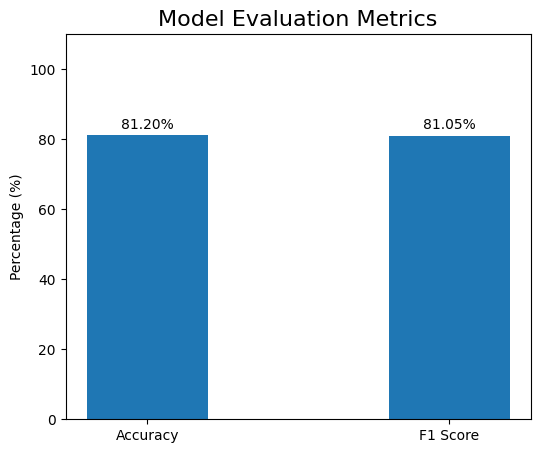

In [15]:
metrics = ['Accuracy', 'F1 Score']
values = [accuracy * 100, f1 * 100]

# Plots!
plt.figure(figsize=(6, 5))
bars = plt.bar(metrics, values, width=0.4)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1, f'{yval:.2f}%', ha='center', va='bottom')

plt.title('Model Evaluation Metrics', fontsize=16)
plt.ylim(0, 110)
plt.ylabel('Percentage (%)')
plt.show()

# Predicted label distribution
I will plot pie-chart and bar-chart to visualize % proportion of each class (Positive/Negative)

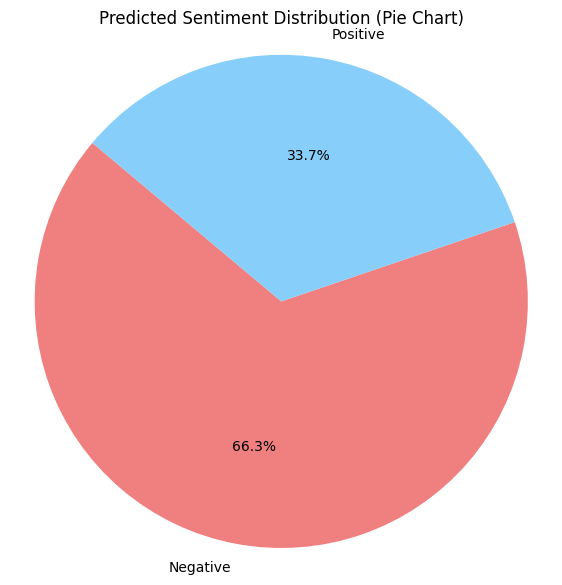

In [16]:
# Pie-chart
label_mapping = {
    0.0: "Negative",
    1.0: "Positive"
}
my_predictions_pd['Predicted_Sentiment'] = my_predictions_pd['predicted_label'].map(label_mapping)
predicted_counts = my_predictions_pd['Predicted_Sentiment'].value_counts()

plt.figure(figsize=(7, 7))
plt.pie(
    predicted_counts,
    labels=predicted_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=["lightcoral", "lightskyblue"]
)
plt.title("Predicted Sentiment Distribution (Pie Chart)")
plt.axis('equal')
plt.show()

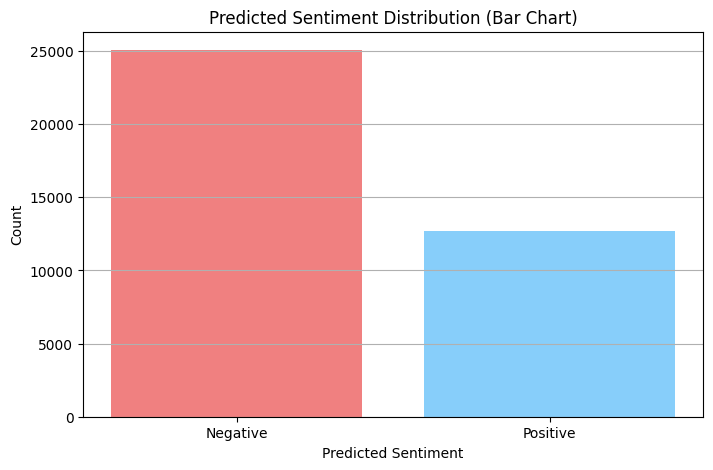

In [17]:
# Bar Chart
plt.figure(figsize=(8, 5))
plt.bar(predicted_counts.index, predicted_counts.values, color=["lightcoral", "lightskyblue"])
plt.xlabel("Predicted Sentiment")
plt.ylabel("Count")
plt.title("Predicted Sentiment Distribution (Bar Chart)")
plt.grid(axis='y')
plt.show()